<a href="https://colab.research.google.com/github/bipinKrishnan/tensorflow_to_pytorch/blob/master/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

## Load the data

In [2]:
import numpy as np
import requests
import io
from PIL import Image

In [3]:
response = requests.get('https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
cat_img = Image.open(io.BytesIO(response.content))

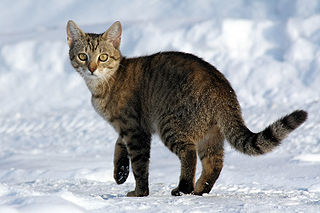

In [4]:
cat_img

In [5]:
cat_array = np.array(cat_img)

## Augmentation and visualizing

In [6]:
import matplotlib.pyplot as plt

In [7]:
def visualize(original, augmented):
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.title('Original Image')
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.title('Augmented Image')
  plt.imshow(augmented)

In [8]:
#flipping along axis 1 - (column)
flipped = torch.flip(torch.from_numpy(cat_array), [1])

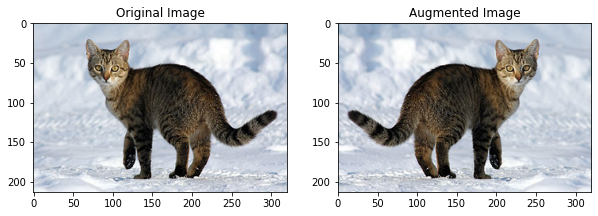

In [9]:
visualize(cat_array, flipped.numpy())

## Operations on Image

In [10]:
from torchvision.transforms import transforms

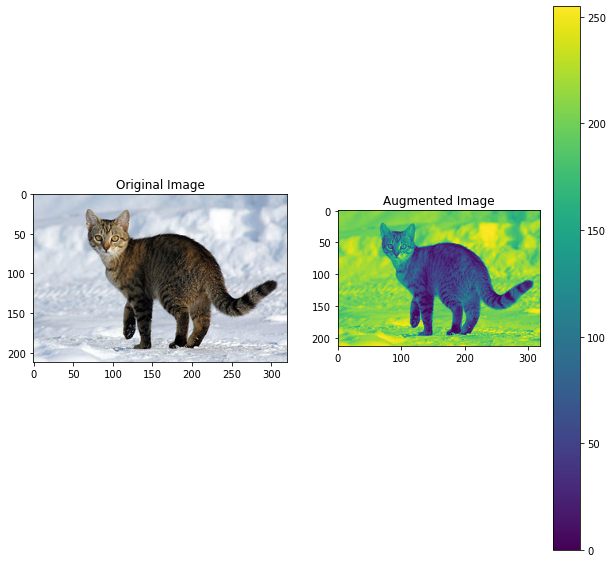

In [11]:
#grayscaling the image
grayscale = transforms.Grayscale(1)
cat_gray = np.array(grayscale(cat_img))

visualize(cat_array, cat_gray)
plt.colorbar()

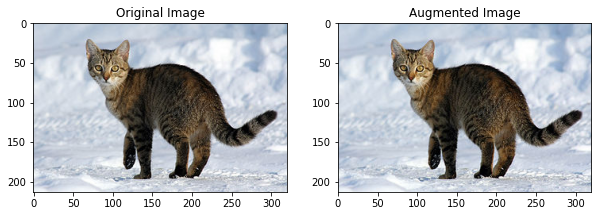

In [12]:
#saturating the image
saturate = transforms.ColorJitter(saturation=3)

cat_sat = np.array(saturate(cat_img))

visualize(cat_array, cat_sat)

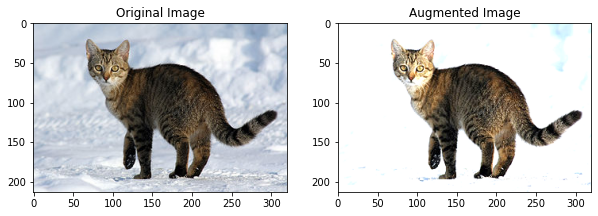

In [13]:
#change image brightness
brightness = transforms.ColorJitter(brightness=0.6)

cat_b = np.array(brightness(cat_img))

visualize(cat_array, cat_b)

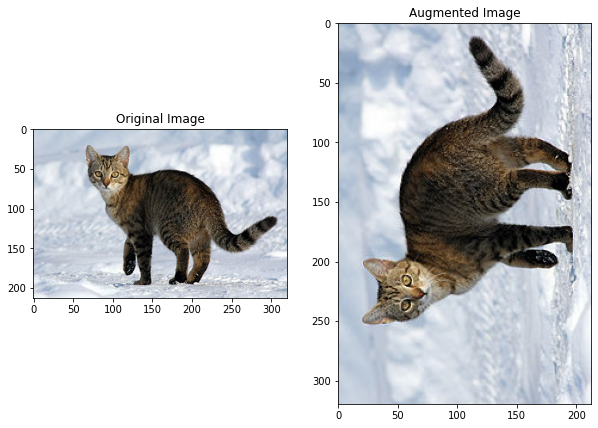

In [14]:
#rotate the image
cat_r = torch.rot90(torch.from_numpy(cat_array))

visualize(cat_array, cat_r.numpy())

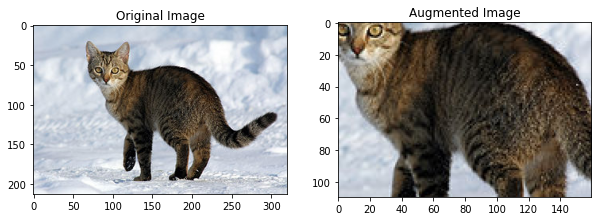

In [15]:
#crop the image
crop = transforms.CenterCrop((110, 160))

cat_crop = np.array(crop(cat_img))

visualize(cat_array, cat_crop)

## Training on an augmented data

In [16]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [17]:
#apply augmentations to the image
transformation = transforms.Compose(
    [transforms.RandomCrop((34, 34), pad_if_needed=True), 
     transforms.ColorJitter(brightness=0.5),
     transforms.RandomCrop((28, 28)),
     transforms.ToTensor()]
)

In [18]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transformation)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


--> There will be no increase in train data

--> Transformations are done on the fly at each iteration

--> No increase in size of data at disk

In [19]:
len(train_data), len(test_data)

(60000, 10000)

In [20]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [21]:
bs = 64

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_data, batch_size=bs)

# Create model

In [31]:
from torch import nn
from torch import optim
from pytorch_lightning.metrics.functional import accuracy

from tqdm.notebook import tqdm

In [32]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [33]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Sequential(
        nn.Linear(784, 4096),
        nn.ReLU(),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, 10)
    )

  def forward(self, inputs):
    inputs = inputs.view(inputs.size(0), -1)
    out = self.l1(inputs)

    return out

In [62]:
model = Model()
model = model.to(device)

In [63]:
opt = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [64]:
def evaluation(dataloader):
  for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    _, pred = torch.max(output.data, 1)

  return accuracy(pred, labels)

In [ ]:
epochs=10
acc_hist = []
val_acc_hist = []

for epoch in range(epochs):
  for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
    images, labels = images.to(device), labels.to(device) 
    opt.zero_grad()

    output = model(images)
    loss = criterion(output, labels)

    loss.backward()
    opt.step()
    _, pred = torch.max(output.data, 1)

  acc = accuracy(pred, labels)
  val_acc = evaluation(test_loader)

  acc_hist.append(acc.item())
  val_acc_hist.append(val_acc.item())

  print("Epoch: %d/%d\tloss: %0.2f\tacc: %0.2f\tval_acc: %0.2f"%(epoch+1, epochs, loss.item(), acc, val_acc))


# Plot the accuracy

Text(0.5, 0, 'Epochs')

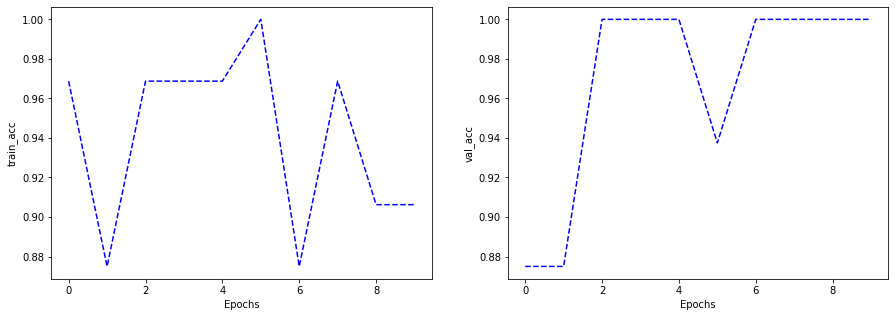

In [73]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc_hist, 'b--')
plt.xlabel('Epochs')
plt.ylabel('train_acc')

plt.subplot(1, 2, 2)
plt.plot(val_acc_hist, 'b--')
plt.ylabel('val_acc')
plt.xlabel('Epochs')